## Setup

In [26]:
import pandas as pd
import numpy as np
import ruptures as rpt
import plotly.io as pio
import cufflinks as cf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser

pio.templates.default = "seaborn"
pd.options.plotting.backend = "plotly"

%matplotlib inline
%run global.ipynb

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [28]:
%store -r day_df
%store -r covid_cases

In [29]:
df = day_df

In [30]:
df['date'] = pd.to_datetime(df['series'])

## Users

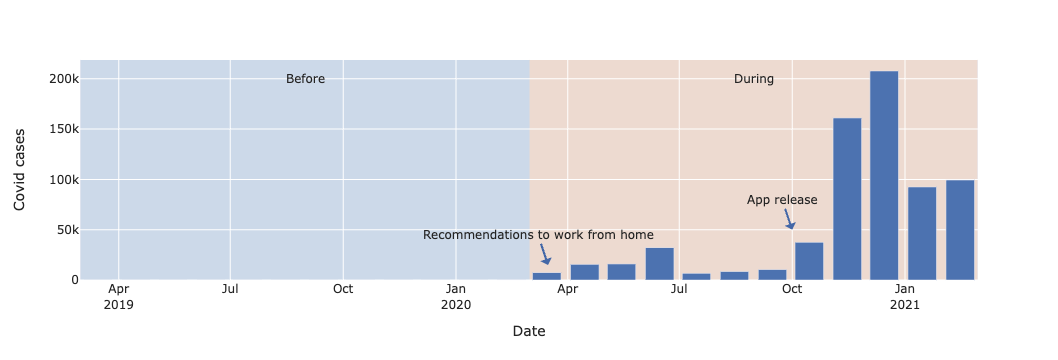

In [31]:
# covid_cases['scaled'] = covid_cases.cases / 125
fig = px.bar(x=covid_cases['date'], y=covid_cases['cases'], labels={ 'x': 'Date', 'y': 'Covid cases' })

fig.update_xaxes(
    dtick="M3",
    tickformat="%b\n%Y")

fig.add_annotation(x=parser.parse('2020-03-16'), y=15000,
            text="Recommendations to work from home",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=parser.parse('2020-10-01'), y=50000,
            text="App release",
            showarrow=True,
            arrowhead=1)

annotate_before_after(fig, True, 200000)

fig.update_layout(showlegend=False)
fig.show()

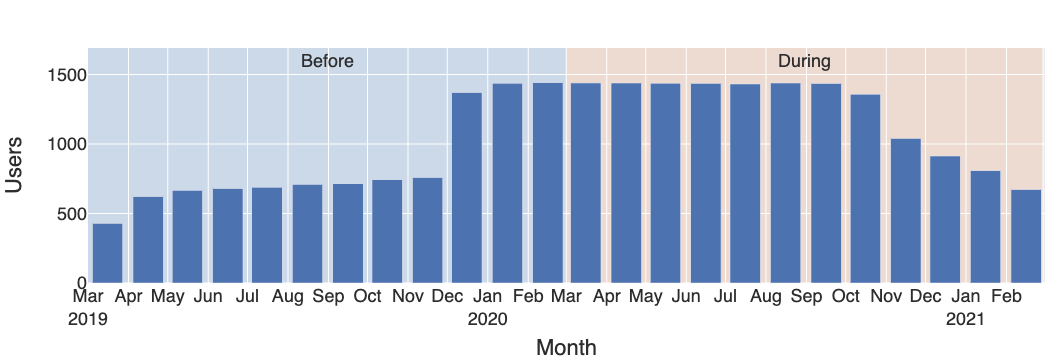

In [37]:
user_counts = df.groupby(['id','series','ageRange']).median().unstack('series')['steps'].count()

fig = px.bar(x=user_counts.index, y=user_counts, labels={ 'x': 'Date', 'y': 'Users' })

annotate_before_after(fig, True, 1600)
style_plot(fig)
fig.update_layout(height=100)
fig.update_xaxes(title="Month")
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

# plt.gcf().set_size_inches(600/96, 100/96)

fig.show()

In [8]:
df = df[(df.date > '2018-09-16') & (df.date < '2021-03-01')]
df.groupby(['id','series']).median().unstack('series')['steps'].count()

series
2019-03-16     470
2019-04-16     731
2019-05-16     791
2019-06-16     809
2019-07-16     823
2019-08-16     844
2019-09-16     849
2019-10-16     884
2019-11-16     903
2019-12-16    1547
2020-01-16    1637
2020-02-16    1639
2020-03-16    1638
2020-04-16    1639
2020-05-16    1637
2020-06-16    1630
2020-07-16    1625
2020-08-16    1627
2020-09-16    1619
2020-10-16    1538
2020-11-16    1203
2020-12-16    1067
2021-01-16     958
2021-02-16     811
dtype: int64

## Steps each month

In [9]:
months = df.groupby(['hour','series']).median().unstack('series')['steps'].sum()

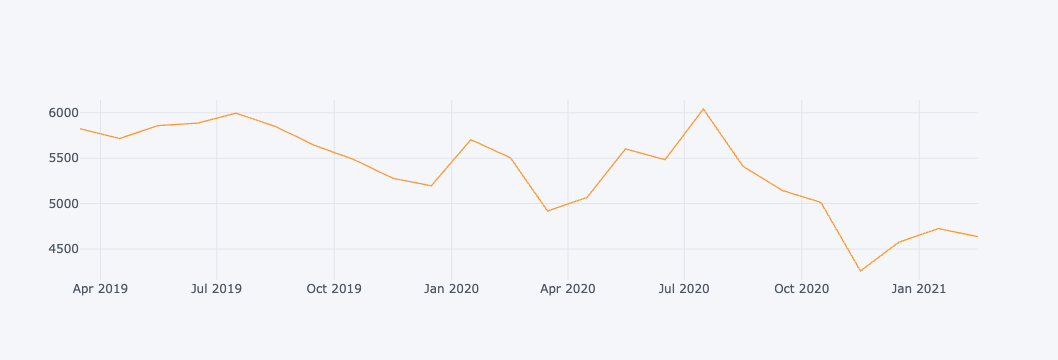

In [10]:
months.iplot()

## Calculate change each month

In [11]:
# period_before = df[df.date < '2020-03-01'].groupby(['hour','series']).median().unstack('series')['steps'].sum().median()
period_before = df[df['period'] == 'Before'].groupby(['hour','series']).median().unstack('series')['steps'].sum().median()
period_before

5710.443447967162

In [12]:
month_list = months.keys()
rows = []
for month in month_list:
    value = months[month]
    rows.append([month, value, value - period_before])
    
months_diff = pd.DataFrame(rows, columns=['month', 'steps', 'diff'])

In [13]:
months_diff['cu_sum'] = months_diff['diff'].cumsum()

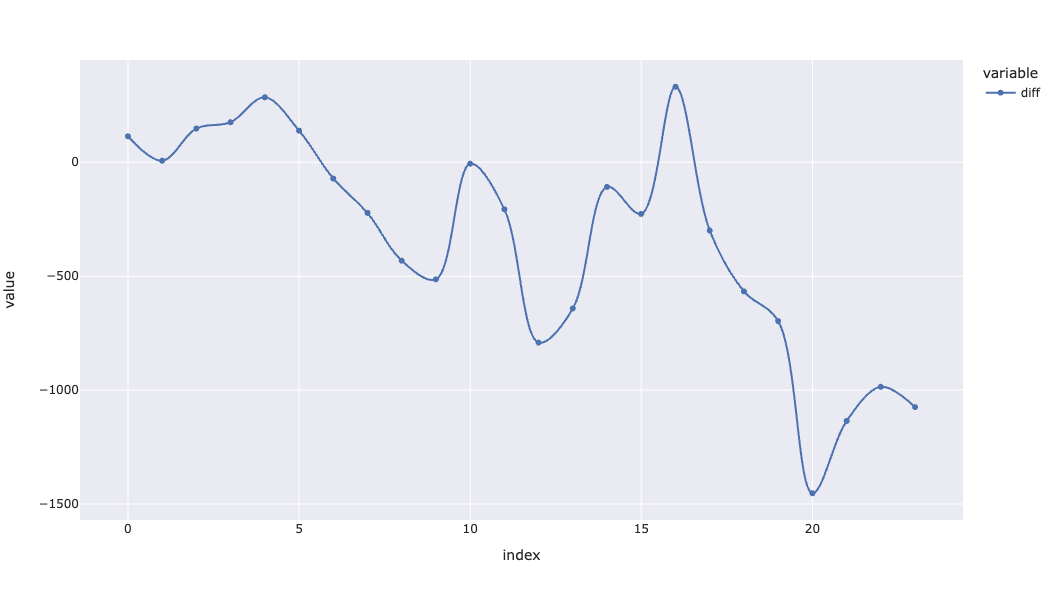

In [14]:
months_diff['diff'].plot.line(markers=True, line_shape='spline', height=600)

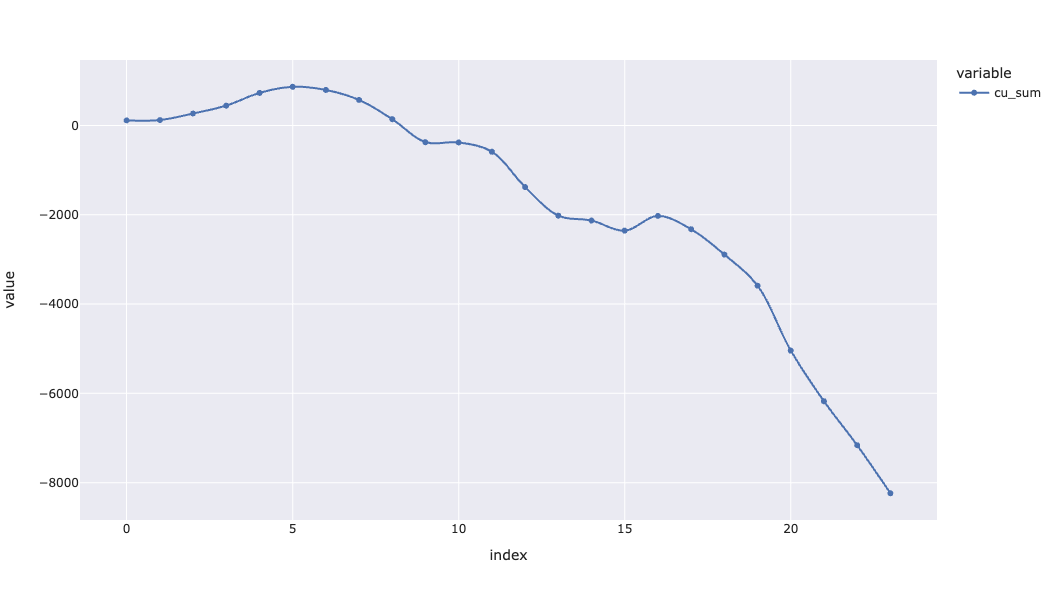

In [15]:
months_diff['cu_sum'].plot.line(markers=True, line_shape='spline', height=600)

## Steps over time vs Covid cases

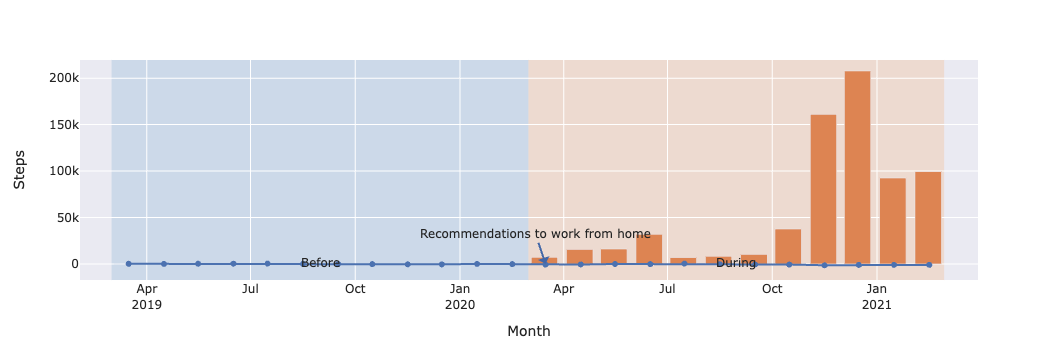

In [16]:
# covid_cases['scaled'] = covid_cases.cases / 125
fig = px.line(x=
              months_diff['month'], y=months_diff['diff'], markers=True)
fig.add_bar(x=covid_cases['date'], y=covid_cases['cases'])

fig.update_xaxes(
    title="Month",
    dtick="M3",
    tickformat="%b\n%Y")

fig.update_yaxes(title="Steps")

fig.add_annotation(x=parser.parse('2020-03-16'), y=100,
            text="Recommendations to work from home",
            showarrow=True,
            arrowhead=1)

annotate_before_after(fig)

fig.update_layout(showlegend=False)
fig.show()

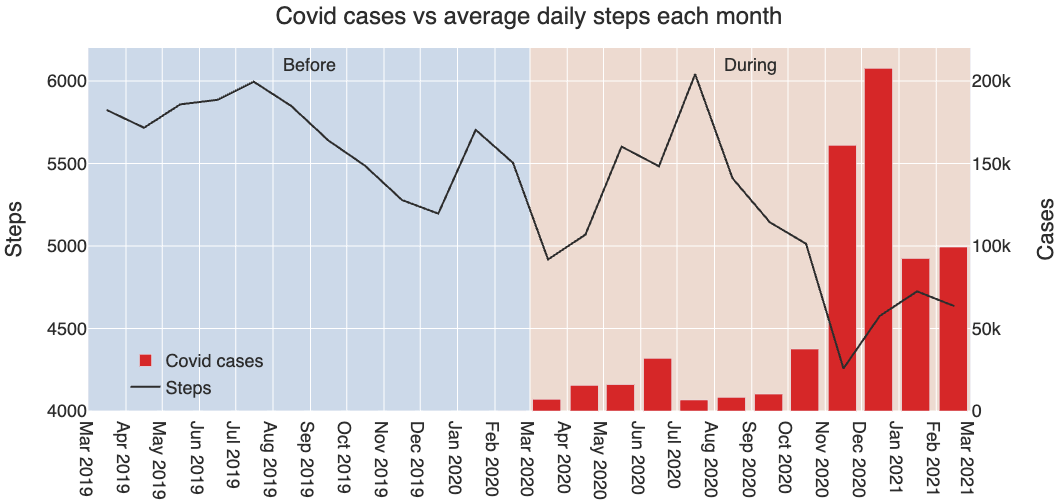

<Figure size 450x300 with 0 Axes>

In [51]:
# covid_cases['scaled'] = covid_cases.cases / 150
fig = make_subplots(specs=[[{ "secondary_y": True }]])
fig.add_trace(go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases", marker_color=px.colors.qualitative.D3[3]), secondary_y=False,)
fig.add_trace(go.Line(x=months_diff['month'], y=months_diff['steps'], name="Steps", line=dict(color=black_color)), secondary_y=True)
fig.update_layout(yaxis=dict(nticks=5), yaxis2=dict(nticks=5))
fig.update_layout(
    title_text="Covid cases vs average daily steps each month"
)
fig.update_yaxes(title_text="Cases", secondary_y=False)
fig.update_yaxes(title_text="Steps", secondary_y=True)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

annotate_before_after(fig, True, 210000)
style_plot(fig)
fig.update_layout(legend=dict(
        bgcolor="rgba(255,255,255, 0.0)",
        yanchor="top",
        y=0.19,
        xanchor="left",
        x=0.04
    ))
fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left', 'range': [4000, 6200] },
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right', 'range': [0, 220000]}))

plt.gcf().set_size_inches(600/96, 400/96)

fig.show()

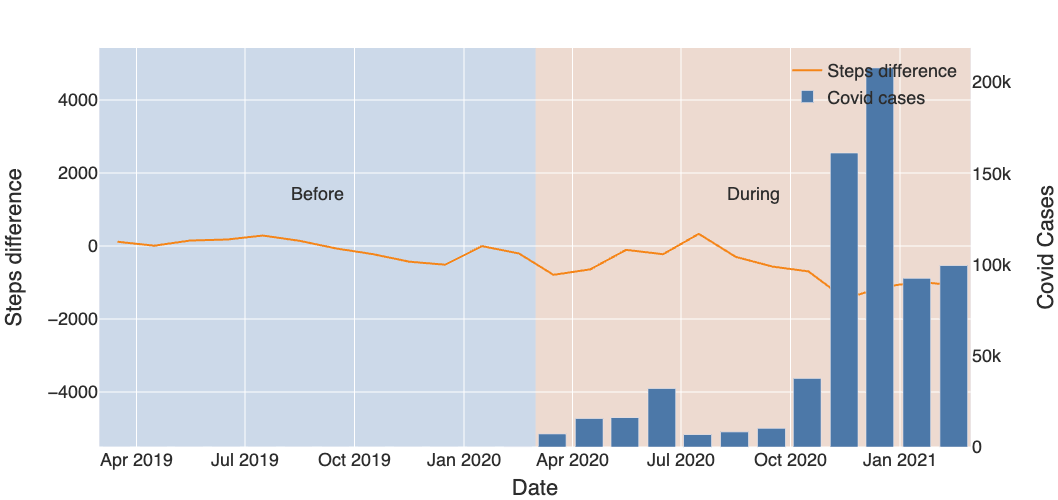

In [21]:
steps = go.Line(x=months_diff['month'], y=months_diff['diff'], name="Steps difference", mode="lines", line=dict(color=px.colors.qualitative.T10[1]))
cases = go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases", yaxis='y2', marker_color=px.colors.qualitative.T10[0])


layout = go.Layout(xaxis=dict(title="Date"),
                   yaxis=dict(title='Steps difference', scaleanchor="y2", scaleratio=20),
                   yaxis2=dict(title='Covid Cases',
                               overlaying='y',
                               showgrid=False,
                               side='right'))

fig = go.Figure(data=[steps, cases], layout=layout)
annotate_before_after(fig)
style_plot(fig)
fig.show()

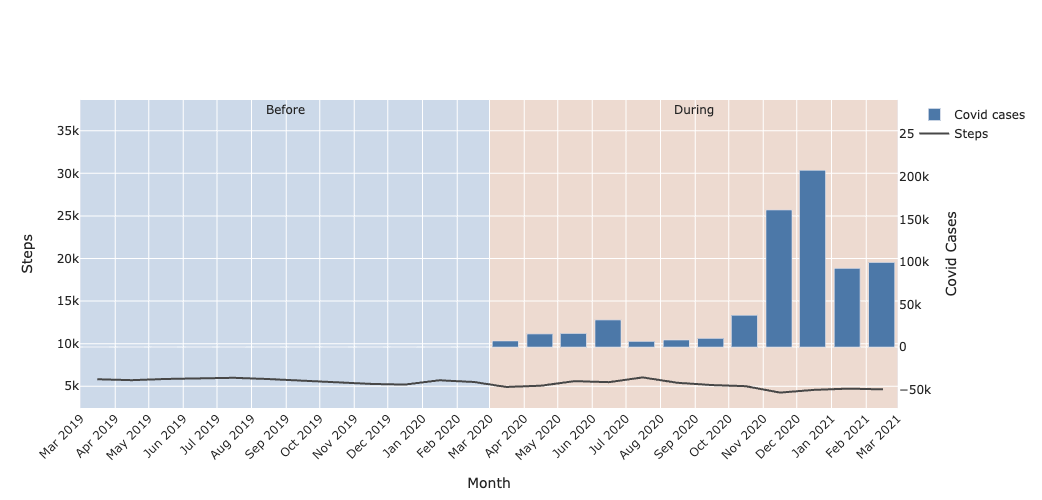

In [22]:
steps = go.Line(x=months_diff['month'], y=months_diff['steps'], name="Steps", mode="lines", line=dict(color='#474747'))
cases = go.Bar(x=covid_cases['date'], y=covid_cases['cases'], name="Covid cases", yaxis='y2', marker_color=px.colors.qualitative.T10[0], opacity=1)


# tickformat='%Y/%m'
layout = go.Layout(xaxis=dict(title="Month", tickmode='auto',tickangle=-45, nticks=30),
                   yaxis=dict(title='Steps', scaleanchor="y2", scaleratio=10),
                   yaxis2=dict(title='Covid Cases',
                               overlaying='y',
                               showgrid=False,
                               side='right'))

fig = go.Figure(data=[cases, steps], layout=layout)
# fig.data = (fig.data[1],fig.data[0])
# fig.update_layout(height=500, paper_bgcolor='#fff', plot_bgcolor="#fff")
fig.update_layout(height=500)

annotate_before_after(fig, True, 37500) 
fig.show()

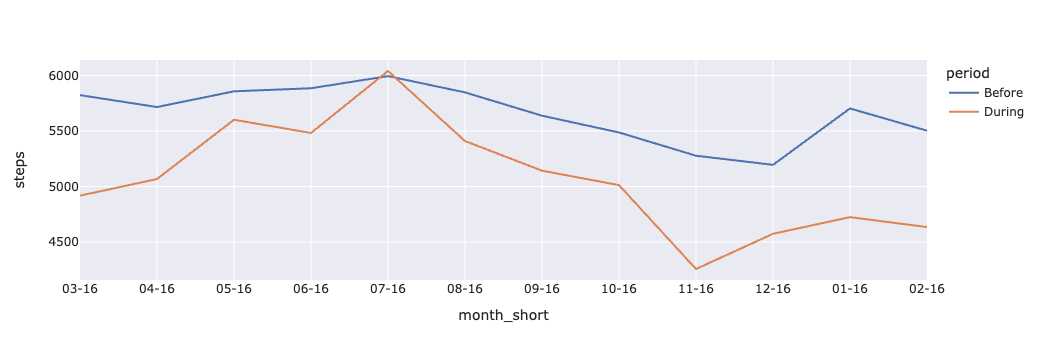

In [23]:
months_diff['period'] = np.select([
    (months_diff.month > before_period_start) & (months_diff.month < before_period_end),
    (months_diff.month > after_period_start) & (months_diff.month < after_period_end)
], ['Before', 'During'], default='none')
months_diff['month_short'] = months_diff['month'].str[5:]

months_diff.plot(x="month_short", y="steps", color="period")

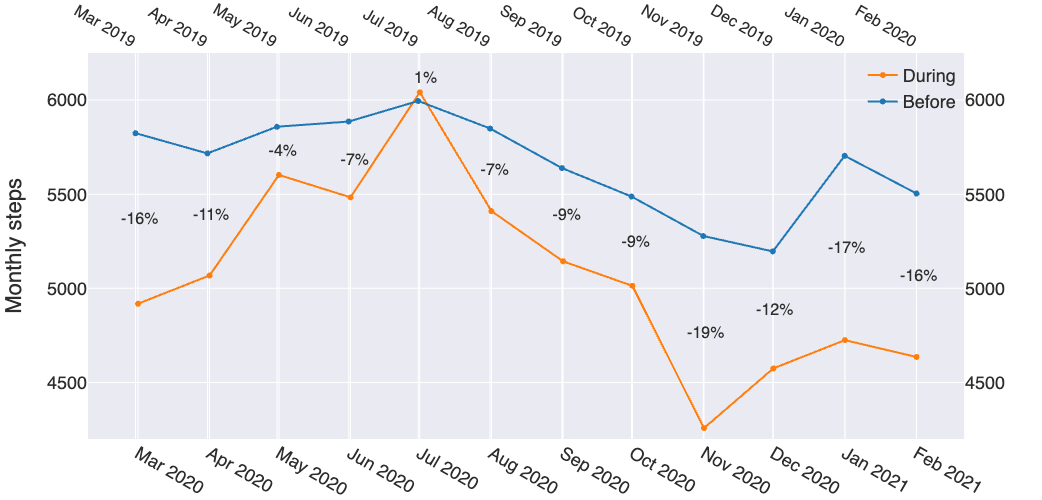

<Figure size 450x300 with 0 Axes>

In [25]:
%run global.ipynb

months_before = months_diff[months_diff['period'] == 'Before']
months_during = months_diff[months_diff['period'] == 'During']


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'});

fig.add_trace(
    go.Line(x=months_during['month'],
           y=months_during['steps'],
           name="During",
           line_color=during_color
          ), secondary_y=False)
fig.add_trace(
    go.Line(x=months_before['month'],
           y=months_before['steps'],
               name="Before",
               line_color=before_color), secondary_y=True)
fig.data[1].update(xaxis='x2')
fig.update_layout(height=500)
fig.update_yaxes(range=[4200,6250])
fig.update_layout(xaxis=dict(tickvals=months_during.month, tickfont=dict(size=16)), xaxis2_tickformat = '%b %Y')
fig.update_layout(xaxis2=dict(tickvals=months_before.month, tickfont=dict(size=16)), xaxis_tickformat = '%b %Y')
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)
fig.update_layout(yaxis_title="Monthly steps")

style_plot(fig)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9375
))

annotateMonthDiffs(fig, months_before, months_during)

plt.gcf().set_size_inches(600/96, 400/96)

fig.show()

In [25]:
months_before['month']

0     2019-03-16
1     2019-04-16
2     2019-05-16
3     2019-06-16
4     2019-07-16
5     2019-08-16
6     2019-09-16
7     2019-10-16
8     2019-11-16
9     2019-12-16
10    2020-01-16
11    2020-02-16
Name: month, dtype: object

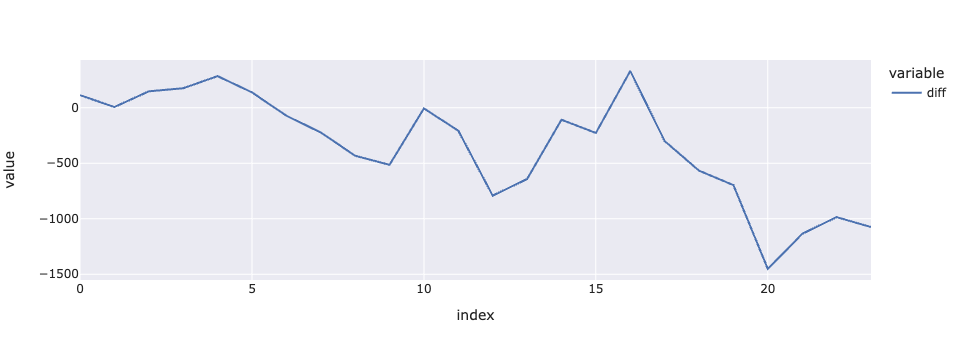

In [26]:
months_diff['diff'].plot()